<a href="https://colab.research.google.com/github/geoffrey-lawhorn/Portfolio/blob/main/AbaloneRegressionNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Regression with an Abalone Dataset**

## **Background**

Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task.  Other measurements, which are easier to obtain, are used to predict the age.  Further information, such as weather patterns and location (hence food availability) may be required to solve the problem.

## **Data**

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Abalone dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

- Files
   - train.csv - the training dataset; Rings is the integer target
   - test.csv - the test dataset; your objective is to predict the value of Rings for each row
   - sample_submission.csv - a sample submission file in the correct format

In [2]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Importing libraries for data visualization
import seaborn as sns

import matplotlib.pyplot as plt

# Importing libraries for building linear regression model
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Importing libraries for scaling the data
from sklearn.preprocessing import MinMaxScaler

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [72]:
path = '/content/drive/MyDrive/Kaggle/1. Abalone Regression'
train = pd.read_csv(path+'/train.csv')
test = pd.read_csv(path+'/test.csv')

In [5]:
train.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [71]:
test.head()

AttributeError: 'tuple' object has no attribute 'head'

**Observations**
- 'id' variable likely does not have predictive power
- 'Rings' is the dependent variable in this case

In [7]:
train = train.drop(['id'], axis = 1)
test = test.drop(['id'], axis = 1)

## **Check the Information of the Training Data**

In [8]:
train.shape

(90615, 9)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             90615 non-null  object 
 1   Length          90615 non-null  float64
 2   Diameter        90615 non-null  float64
 3   Height          90615 non-null  float64
 4   Whole weight    90615 non-null  float64
 5   Whole weight.1  90615 non-null  float64
 6   Whole weight.2  90615 non-null  float64
 7   Shell weight    90615 non-null  float64
 8   Rings           90615 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 6.2+ MB


**Observations**

- We are dealing with all numeric variables aside from the sex of the tree.
- There are no null values within any of the 9 columns

In [10]:
(train.isnull().sum() / train.shape[0])*100

Sex               0.0
Length            0.0
Diameter          0.0
Height            0.0
Whole weight      0.0
Whole weight.1    0.0
Whole weight.2    0.0
Shell weight      0.0
Rings             0.0
dtype: float64

In [19]:
train.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight', 'Rings'],
      dtype='object')

## **EDA and Data Preprocessing**

Now that we have an understanding of the business problem we want to solve, and we have loaded the datasets, the next step to follow is to have a better understanding of the dataset, i.e., what is the distribution of the variables, what are different relationships that exist between variables, etc. If there are any data anomalies like missing values or outliers, how do we treat them to prepare the dataset for building the predictive model?

### **Univariate Analysis**

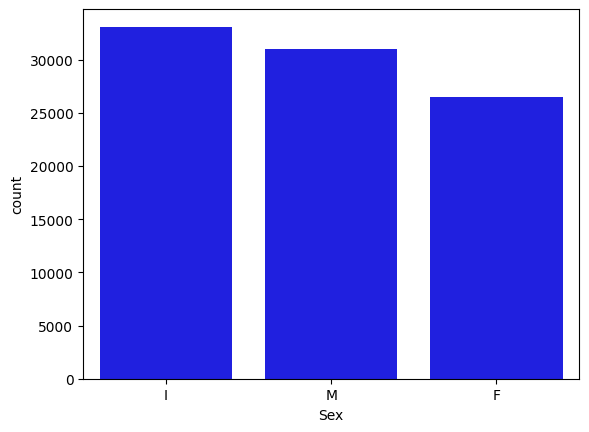

In [15]:
# fig, axes = plt.subplots(2, 2, figsize = (18, 10))
# fig.suptitle('Bar plot for all categorical variables in the dataset')

sns.countplot(x = 'Sex', data = train, color = 'blue',
              order = train['Sex'].value_counts().index);

**Observations**

- From the plot above we can see that there are three categories for sex.
- It is currently unknown as to what 'I' means in the context of Sex, but we will take that for now to mean as an undisclosed field.

Next we will examine numeric columns from a univariate POV.

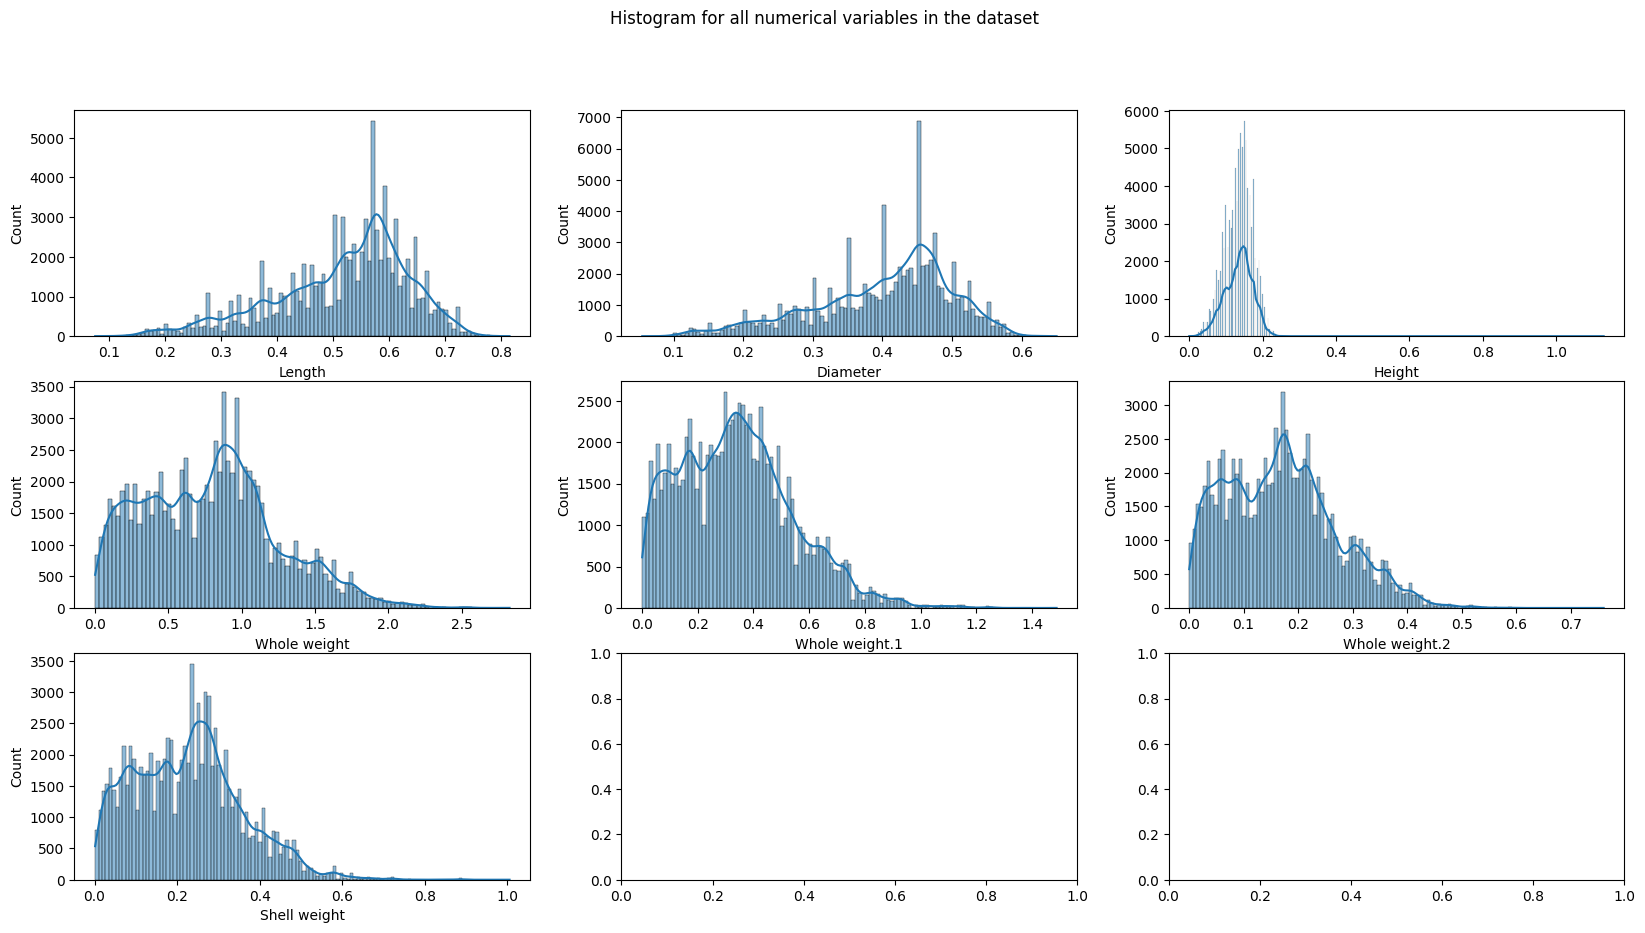

In [25]:
fig, axes = plt.subplots(3, 3, figsize = (20, 10))

fig.suptitle('Histogram for all numerical variables in the dataset')

sns.histplot(x = 'Length', data = train, kde = True, ax = axes[0, 0]);

sns.histplot(x='Diameter', data = train, kde = True, ax = axes[0, 1]);

sns.histplot(x='Height', data = train, kde = True, ax = axes[0, 2]);

sns.histplot(x = 'Whole weight', data = train, kde = True, ax = axes[1, 0]);

sns.histplot(x='Whole weight.1', data = train, kde = True, ax = axes[1, 1]);

sns.histplot(x='Whole weight.2', data = train, kde = True, ax = axes[1, 2]);

sns.histplot(x='Shell weight', data = train, kde = True, ax = axes[2, 0]);

In [24]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Length,90615.0,0.517098,0.118217,0.0750,0.4450,0.5450,0.6000,0.8150
Diameter,90615.0,0.401679,0.098026,0.0550,0.3450,0.4250,0.4700,0.6500
Height,90615.0,0.135464,0.038008,0.0000,0.1100,0.1400,0.1600,1.1300
Whole weight,90615.0,0.789035,0.457671,0.0020,0.4190,0.7995,1.0675,2.8255
Whole weight.1,90615.0,0.340778,0.204428,0.0010,0.1775,0.3300,0.4630,1.4880
Whole weight.2,90615.0,0.169422,0.100909,0.0005,0.0865,0.1660,0.2325,0.7600
Shell weight,90615.0,0.225898,0.130203,0.0015,0.1200,0.2250,0.3050,1.0050
Rings,90615.0,9.696794,3.176221,1.0000,8.0000,9.0000,11.0000,29.0000


**Observations**

- Length is slightly skewed left, with 50% of hte data falling between 0.55 and 0.82
- Diameter seems to follow a very similar distribution to Length
- Height is skewed right slightly, with several outliers (this should be fixed by max/min scaling)
- Whole Weight, Whole Weight 1, Whole Weight 2, and Shell Weight also follow right skewed distributions

## **Bivariate Analysis**

Now, let's move ahead with bivariate analysis to understand how variables are related to each other and if there is a strong relationship between dependent and independent variables present in the training dataset.

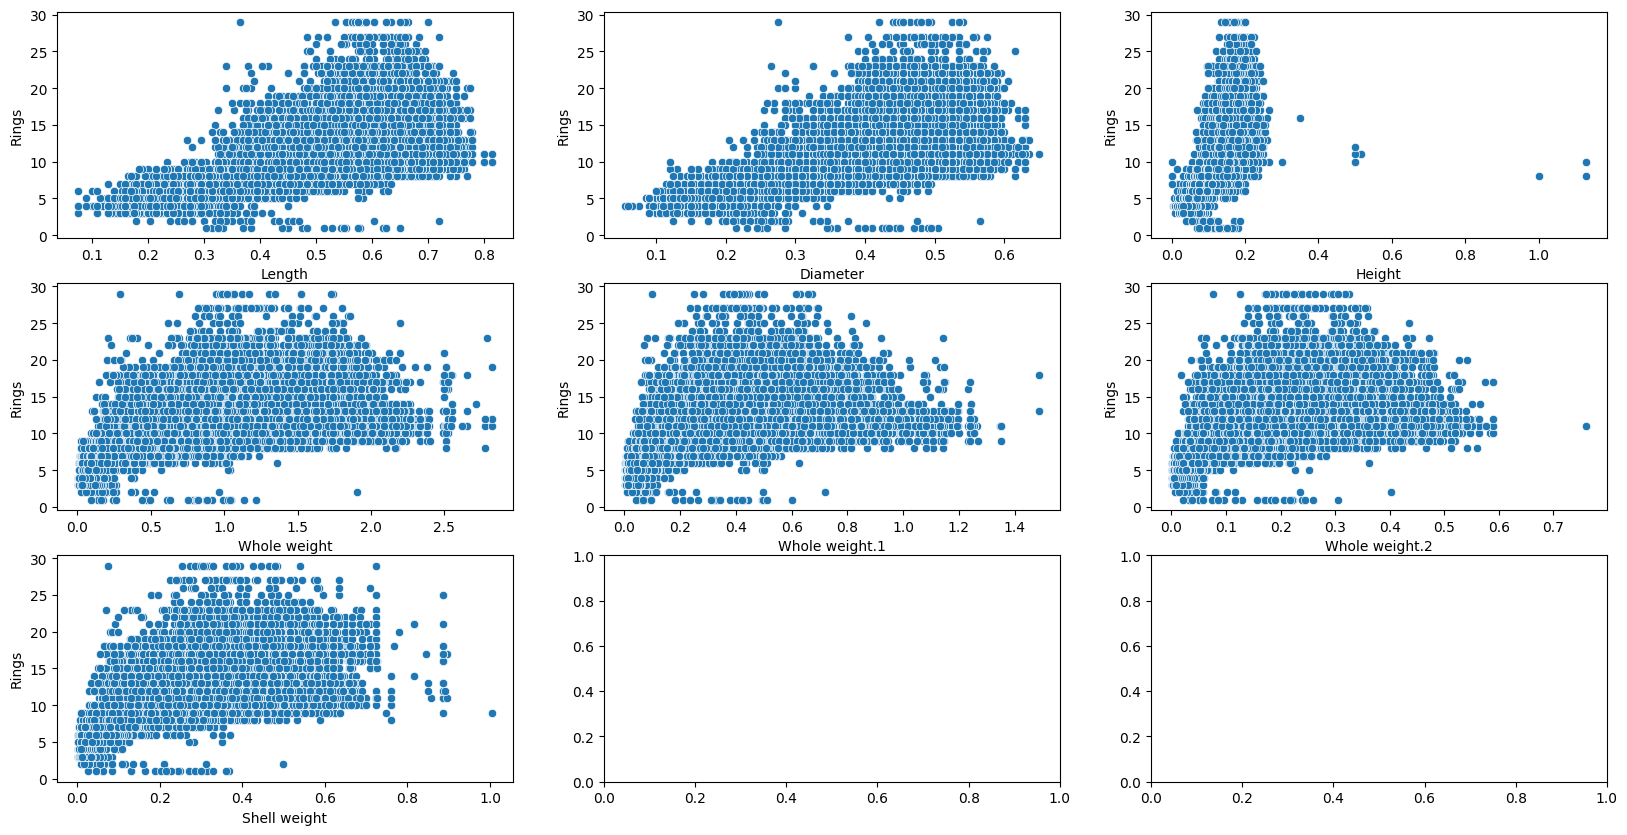

In [31]:
fig, axes = plt.subplots(3, 3, figsize = (20, 10))

sns.scatterplot(x = 'Length', y = 'Rings', data = train, ax = axes[0,0]);
sns.scatterplot(x='Diameter', y = 'Rings', data = train, ax = axes[0,1]);
sns.scatterplot(x='Height', y = 'Rings', data = train, ax = axes[0, 2]);
sns.scatterplot(x = 'Whole weight', y = 'Rings', data = train, ax = axes[1, 0]);
sns.scatterplot(x='Whole weight.1', y = 'Rings', data = train, ax = axes[1, 1]);
sns.scatterplot(x='Whole weight.2', y = 'Rings', data = train, ax = axes[1, 2]);
sns.scatterplot(x='Shell weight', y = 'Rings', data = train, ax = axes[2, 0]);

**Observations**

- Overall it appears we have positive correlation with fields such as length, diameter, Whole Weight, Whole Weight 1, Whole Weight 2, and Shell Weight to some extent
- Height has some correlated effect on rings it appears, but rendering on chart could be affected by outliers.

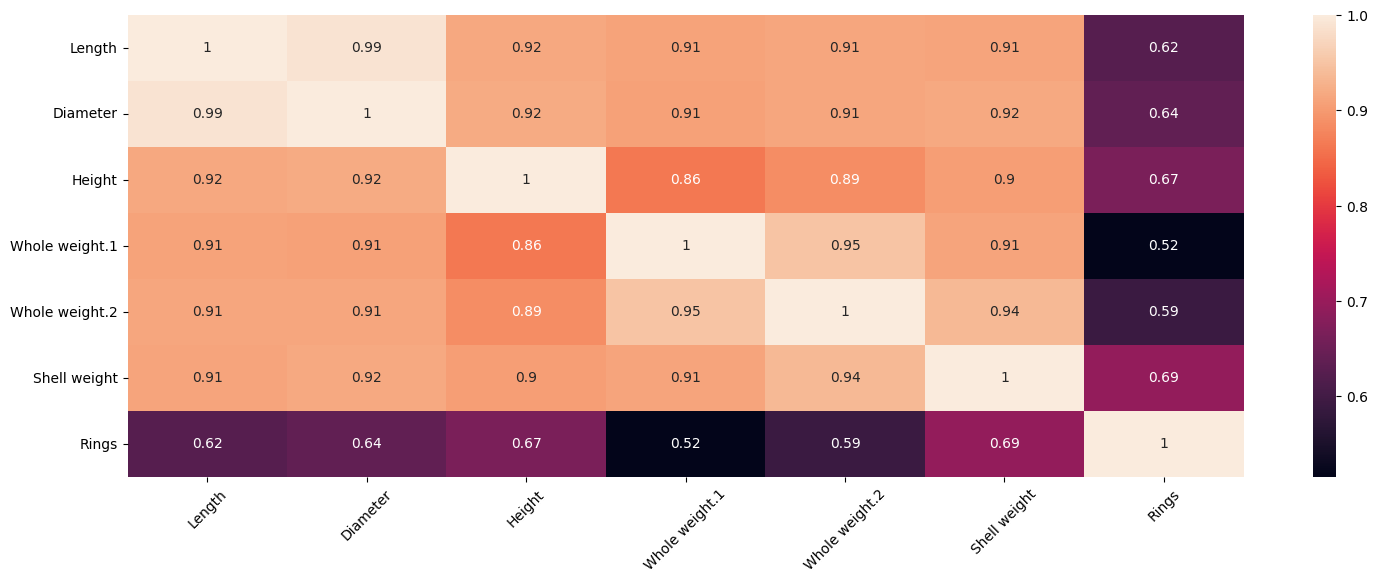

In [35]:
train2 = train.drop(['Whole weight'], axis = 1)

fig = plt.figure(figsize = (18, 6))

sns.heatmap(train2.corr(numeric_only=True), annot = True);

plt.xticks(rotation = 45);

**Observations**

- Lots of high correlation values that appear within the data. It appears that Whole Weight might be the only weight that is needed.
- We'll want to remove whole weight and use the components that add up to whole weight instead.

## **Modeling**

Now, that we have analyzed all the variables in the dataset, we are ready to start building the model. We have observed that not all the independent variables are important to predict the outcome variable. But at the beginning, we will use all the variables, and then from the model summary, we will decide on which variable to remove from the model. Model building is an iterative task.

In [36]:
# We are removing the outcome variable from the feature set
# Removing Whole weight as it is already represented by the other weights in the set
train_features = train.drop(['Rings', 'Whole weight'], axis = 1)

# And then we are extracting the outcome variable separately
train_target = train['Rings']

In [37]:
# Creating dummy variables for the categorical variables
train_features = pd.get_dummies(train_features, drop_first = True)

train_features.head()

,Length,Diameter,Height,Whole weight.1,Whole weight.2,Shell weight,Sex_I,Sex_M
0,0.550,0.430,0.150,0.3285,0.1465,0.2400,False,False
1,0.630,0.490,0.145,0.4580,0.2765,0.3200,False,False
2,0.160,0.110,0.025,0.0055,0.0030,0.0050,True,False
3,0.595,0.475,0.150,0.3755,0.2055,0.2500,False,True
4,0.555,0.425,0.130,0.3695,0.1600,0.1975,True,False


In [38]:
# Creating an instance of the MinMaxScaler
scaler = MinMaxScaler()

# Applying fit_transform on the training features data
train_features_scaled = scaler.fit_transform(train_features)

# The above scaler returns the data in array format, below we are converting it back to pandas DataFrame
train_features_scaled = pd.DataFrame(train_features_scaled, index = train_features.index, columns = train_features.columns)

train_features_scaled.head()

,Length,Diameter,Height,Whole weight.1,Whole weight.2,Shell weight,Sex_I,Sex_M
0,0.641892,0.630252,0.132743,0.220242,0.192232,0.237668,0.0,0.0
1,0.750000,0.731092,0.128319,0.307330,0.363397,0.317389,0.0,0.0
2,0.114865,0.092437,0.022124,0.003026,0.003292,0.003488,1.0,0.0
3,0.702703,0.705882,0.132743,0.251849,0.269914,0.247633,0.0,1.0
4,0.648649,0.621849,0.115044,0.247814,0.210007,0.195316,1.0,0.0


In [39]:
# Adding the intercept term
train_features_scaled = sm.add_constant(train_features_scaled)

# Calling the OLS algorithm on the train features and the target variable
ols_model_0 = sm.OLS(train_target, train_features_scaled)

# Fitting the Model
ols_res_0 = ols_model_0.fit()

print(ols_res_0.summary())

                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                 1.708e+04
Date:                Wed, 03 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:36:56   Log-Likelihood:            -1.9163e+05
No. Observations:               90615   AIC:                         3.833e+05
Df Residuals:                   90606   BIC:                         3.834e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.9978      0.052     76.

## **Removing Multicollinearity**

Multicollinearity occurs when predictor variables in a regression model are correlated. This correlation is a problem because predictor variables should be independent. If the correlation between independent variables is high, it can cause problems when we fit the model and interpret the results. When we have multicollinearity in the linear model, the coefficients that the model suggests are unreliable.

There are different ways of detecting (or testing) multicollinearity. One such way is the Variation Inflation Factor.

Variance Inflation factor: Variance inflation factor measures the inflation in the variances of the regression parameter estimates due to collinearities that exist among the predictors. It is a measure of how much the variance of the estimated regression coefficient βk is “inflated” by the existence of correlation among the predictor variables in the model.

General Rule of thumb: If VIF is 1, then there is no correlation between the kth predictor and the remaining predictor variables, and hence the variance of β̂k is not inflated at all. Whereas, if VIF exceeds 5 or is close to exceeding 5, we say there is moderate VIF and if it is 10 or exceeds 10, it shows signs of high multicollinearity.

In [40]:
vif_series = pd.Series(
    [variance_inflation_factor(train_features_scaled.values, i) for i in range(train_features_scaled.shape[1])],
    index = train_features_scaled.columns,
    dtype = float)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

const             61.153859
Length            51.199593
Diameter          54.243151
Height             7.799376
Whole weight.1    11.606490
Whole weight.2    15.229951
Shell weight      11.124144
Sex_I              2.386857
Sex_M              1.441956
dtype: float64



In [41]:
train_features_scaled_new = train_features_scaled.drop("Diameter", axis = 1)

vif_series = pd.Series(
    [variance_inflation_factor(train_features_scaled_new.values, i) for i in range(train_features_scaled_new.shape[1])],
    index = train_features_scaled_new.columns,
    dtype = float
)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

const             61.149554
Length            10.139155
Height             7.689717
Whole weight.1    11.605558
Whole weight.2    15.229930
Shell weight      10.863838
Sex_I              2.370803
Sex_M              1.441924
dtype: float64



In [43]:
ols_model_2 = sm.OLS(train_target, train_features_scaled_new)
ols_res_2 = ols_model_2.fit()
print(ols_res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                 1.942e+04
Date:                Wed, 03 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:43:56   Log-Likelihood:            -1.9178e+05
No. Observations:               90615   AIC:                         3.836e+05
Df Residuals:                   90607   BIC:                         3.837e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.0052      0.052     76.

In [44]:
train_features_scaled_new2 = train_features_scaled_new.drop("Whole weight.2", axis = 1)

vif_series = pd.Series(
    [variance_inflation_factor(train_features_scaled_new2.values, i) for i in range(train_features_scaled_new2.shape[1])],
    index = train_features_scaled_new2.columns,
    dtype = float
)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

const             60.605908
Length            10.075879
Height             7.623558
Whole weight.1     7.593053
Shell weight       9.193723
Sex_I              2.350777
Sex_M              1.439361
dtype: float64



In [45]:
ols_model_3 = sm.OLS(train_target, train_features_scaled_new2)
ols_res_3 = ols_model_3.fit()
print(ols_res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                 2.262e+04
Date:                Wed, 03 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:48:04   Log-Likelihood:            -1.9183e+05
No. Observations:               90615   AIC:                         3.837e+05
Df Residuals:                   90608   BIC:                         3.837e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.0527      0.052     77.

In [46]:
train_features_scaled_new3 = train_features_scaled_new2.drop("Length", axis = 1)

vif_series = pd.Series(
    [variance_inflation_factor(train_features_scaled_new3.values, i) for i in range(train_features_scaled_new3.shape[1])],
    index = train_features_scaled_new3.columns,
    dtype = float
)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

const             40.697590
Height             5.901790
Whole weight.1     6.236395
Shell weight       8.908428
Sex_I              2.322770
Sex_M              1.439346
dtype: float64



In [47]:
ols_model_4 = sm.OLS(train_target, train_features_scaled_new3)
ols_res_4 = ols_model_4.fit()
print(ols_res_4.summary())

                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                 2.688e+04
Date:                Wed, 03 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:49:48   Log-Likelihood:            -1.9209e+05
No. Observations:               90615   AIC:                         3.842e+05
Df Residuals:                   90609   BIC:                         3.842e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.7339      0.043    110.

In [48]:
train_features_scaled_new4 = train_features_scaled_new3.drop("Whole weight.1", axis = 1)

vif_series = pd.Series(
    [variance_inflation_factor(train_features_scaled_new4.values, i) for i in range(train_features_scaled_new4.shape[1])],
    index = train_features_scaled_new4.columns,
    dtype = float
)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

const           40.255107
Height           5.661815
Shell weight     5.702101
Sex_I            2.320054
Sex_M            1.438293
dtype: float64



In [49]:
ols_model_5 = sm.OLS(train_target, train_features_scaled_new4)
ols_res_5 = ols_model_5.fit()
print(ols_res_5.summary())

                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                 2.227e+04
Date:                Wed, 03 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:51:39   Log-Likelihood:            -2.0228e+05
No. Observations:               90615   AIC:                         4.046e+05
Df Residuals:                   90610   BIC:                         4.046e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.4072      0.048    113.745   

## **Checking Assumptions and Rebuilding the Model**

In this step, we will check whether the below assumptions hold true or not for the model. In case there is an issue, we will rebuild the model after fixing those issues.

1. Mean of residuals should be 0
2. Normality of error terms
3. Linearity of variables
4. No heteroscedasticity

### **Mean of residuals should be 0 and normality of error terms**

In [50]:
# Residuals
residual = ols_res_5.resid

In [51]:
residual.mean()

2.6510775647865395e-15

- The mean of residuals is very close to 0. Hence, the corresponding assumption is satisfied.

### **Tests for Normality**

**What is the test?**

* Error terms/Residuals should be normally distributed.

* If the error terms are non-normally distributed, confidence intervals may become too wide or narrow. Once the confidence interval becomes unstable, it leads to difficulty in estimating coefficients based on the minimization of least squares.

**What does non-normality indicate?**

* It suggests that there are a few unusual data points that must be studied closely to make a better model.

**How to check the normality?**

* We can plot the histogram of residuals and check the distribution visually.

* It can be checked via QQ Plot. Residuals following normal distribution will make a straight line plot otherwise not.

* Another test to check for normality: The Shapiro-Wilk test.

**What if the residuals are not-normal?**

* We can apply transformations like log, exponential, arcsinh, etc. as per our data.

<Axes: ylabel='Count'>

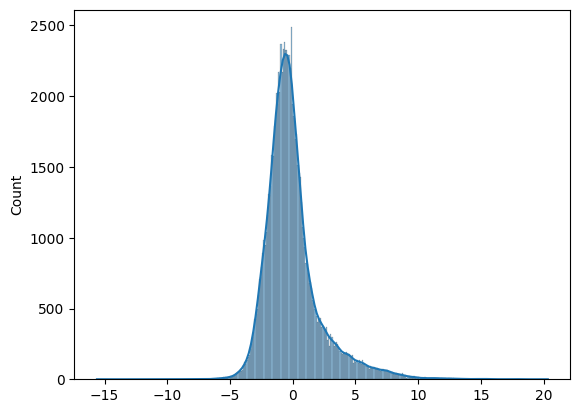

In [52]:
sns.histplot(residual, kde = True)

We can see that the error terms are normally distributed. The assumption of normality is satisfied.

### **Linearity of Variables**

It states that the predictor variables must have a linear relation with the dependent variable.

To test this assumption, we'll plot the residuals and the fitted values and ensure that residuals do not form a strong pattern. They should be randomly and uniformly scattered on the x-axis.

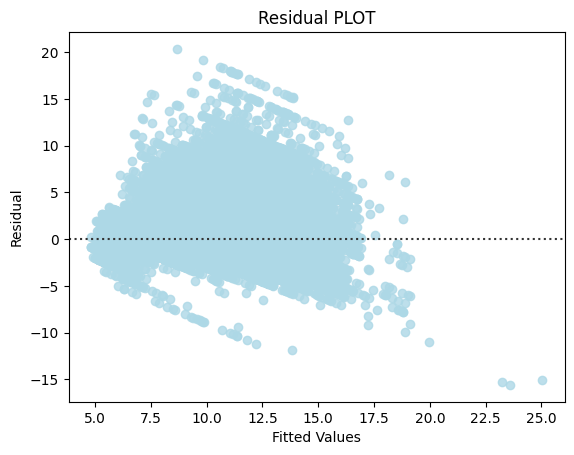

In [53]:
# Predicted values
fitted = ols_res_5.fittedvalues

sns.residplot(x = fitted, y = residual, color = "lightblue")

plt.xlabel("Fitted Values")

plt.ylabel("Residual")

plt.title("Residual PLOT")

plt.show()

We do show some patterns here. We will attempt to fix this with a log transformation.

In [54]:
# Log transformation on the target variable
train_target_log = np.log(train_target)

In [55]:
# Fitting new model with the transformed target variable
ols_model_5 = sm.OLS(train_target_log, train_features_scaled_new4)

ols_res_5 = ols_model_5.fit()

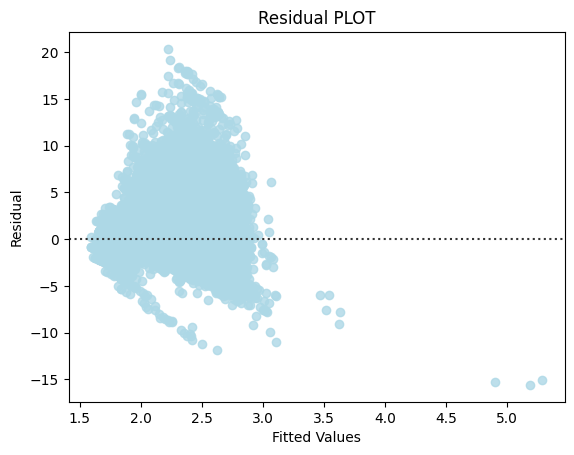

In [56]:
# Predicted values
fitted = ols_res_5.fittedvalues

sns.residplot(x = fitted, y = residual, color = "lightblue")

plt.xlabel("Fitted Values")

plt.ylabel("Residual")

plt.title("Residual PLOT")

plt.show()

In [57]:
print(ols_res_5.summary())

                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                 3.111e+04
Date:                Wed, 03 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:57:23   Log-Likelihood:                 14029.
No. Observations:               90615   AIC:                        -2.805e+04
Df Residuals:                   90610   BIC:                        -2.800e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.6636      0.004    380.800   

### **No Heteroscedasticity**

#### **Test for Homoscedasticity**

* **Homoscedasticity -** If the variance of the residuals are symmetrically distributed across the regression line, then the data is said to homoscedastic.

* **Heteroscedasticity -** If the variance is unequal for the residuals across the regression line, then the data is said to be heteroscedastic. In this case, the residuals can form an arrow shape or any other non symmetrical shape.

- We will use Goldfeld–Quandt test to check homoscedasticity.

    - Null hypothesis : Residuals are homoscedastic

    - Alternate hypothesis : Residuals are hetroscedastic

In [58]:
from statsmodels.stats.diagnostic import het_white

from statsmodels.compat import lzip

import statsmodels.stats.api as sms

In [59]:
import statsmodels.stats.api as sms

from statsmodels.compat import lzip

name = ["F statistic", "p-value"]

test = sms.het_goldfeldquandt(train_target_log, train_features_scaled_new4)

lzip(name, test)

[('F statistic', 0.9767472582970098), ('p-value', 0.9938563338390968)]

- As we observe from the above test, the p-value is greater than 0.05, so we fail to reject the null-hypothesis. That means the residuals are homoscedastic.


We have verified all the assumptions of the linear regression model. The final equation of the model is as follows:

**$\log ($ Rings $)$ $= 1.6636 + 3.4013 *$ Height $ + 0.8161 *$ Shell Weight $ - 0.0843 *$ Sex I $ - 0.0050 *$ Sex M**

In [80]:
without_const = train_features_scaled.iloc[:,1:]
test_features = pd.get_dummies(test, drop_first = True)
test_features = test_features[train_features_scaled.iloc[:,1:].columns]

# Applying transform on the test data
test_features_scaled = scaler.transform(test_features)

test_features_scaled = pd.DataFrame(test_features_scaled, columns = without_const.columns)

test_features_scaled = sm.add_constant(test_features_scaled)

test_features_scaled = test_features_scaled.drop(["Length", "Diameter", "Whole weight.1", "Whole weight.2"], axis = 1)

test_features_scaled.head()

,const,Height,Shell weight,Sex_I,Sex_M
0,1.0,0.137168,0.297957,0.0,1.0
1,1.0,0.141593,0.272546,0.0,1.0
2,1.0,0.123894,0.238166,0.0,1.0
3,1.0,0.128319,0.232686,0.0,1.0
4,1.0,0.097345,0.103139,1.0,0.0


In [81]:
print(ols_res_5.rsquared)

0.578653606751286


In [82]:
print(ols_res_5.mse_resid)

0.04296114555551478


In [101]:
from sklearn.metrics import mean_squared_log_error
pred = ols_res_5.fittedvalues
truth = train["Rings"]
mean_squared_log_error(truth, pred, squared=False)

1.185059171485003

In [104]:
# Fitting linear model

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

linearregression = LinearRegression()

cv_Score11 = cross_val_score(linearregression, train_features_scaled_new4, train_target_log, cv = 10)

cv_Score12 = cross_val_score(linearregression, train_features_scaled_new4, train_target_log, cv = 10,
                             scoring = 'neg_mean_squared_error')


print("RSquared: %0.3f (+/- %0.3f)" % (cv_Score11.mean(), cv_Score11.std()*2))

print("Mean Squared Error: %0.3f (+/- %0.3f)" % (-1*cv_Score12.mean(), cv_Score12.std()*2))

RSquared: 0.578 (+/- 0.012)
Mean Squared Error: 0.043 (+/- 0.002)


Looks as if we are not overfitting at this point since values are coming in simlar to the training results.

In [105]:
# These test predictions will be on a log scale
test_predictions = ols_res_5.predict(test_features_scaled)

# We are converting the log scale predictions to its original scale
test_predictions_inverse_transformed = np.exp(test_predictions)

test_predictions_inverse_transformed

0        10.679342
1        10.618780
2         9.721765
3         9.825142
4         7.349024
           ...    
60406     6.518141
60407     9.636274
60408     9.584385
60409    13.303511
60410     8.143086
Length: 60411, dtype: float64

**Point to remember:** The output of this model is in log scale. So, after making prediction, we need to transform this value from log scale back to its original scale by doing the inverse of log transformation, i.e., taking exponentiation.</font>

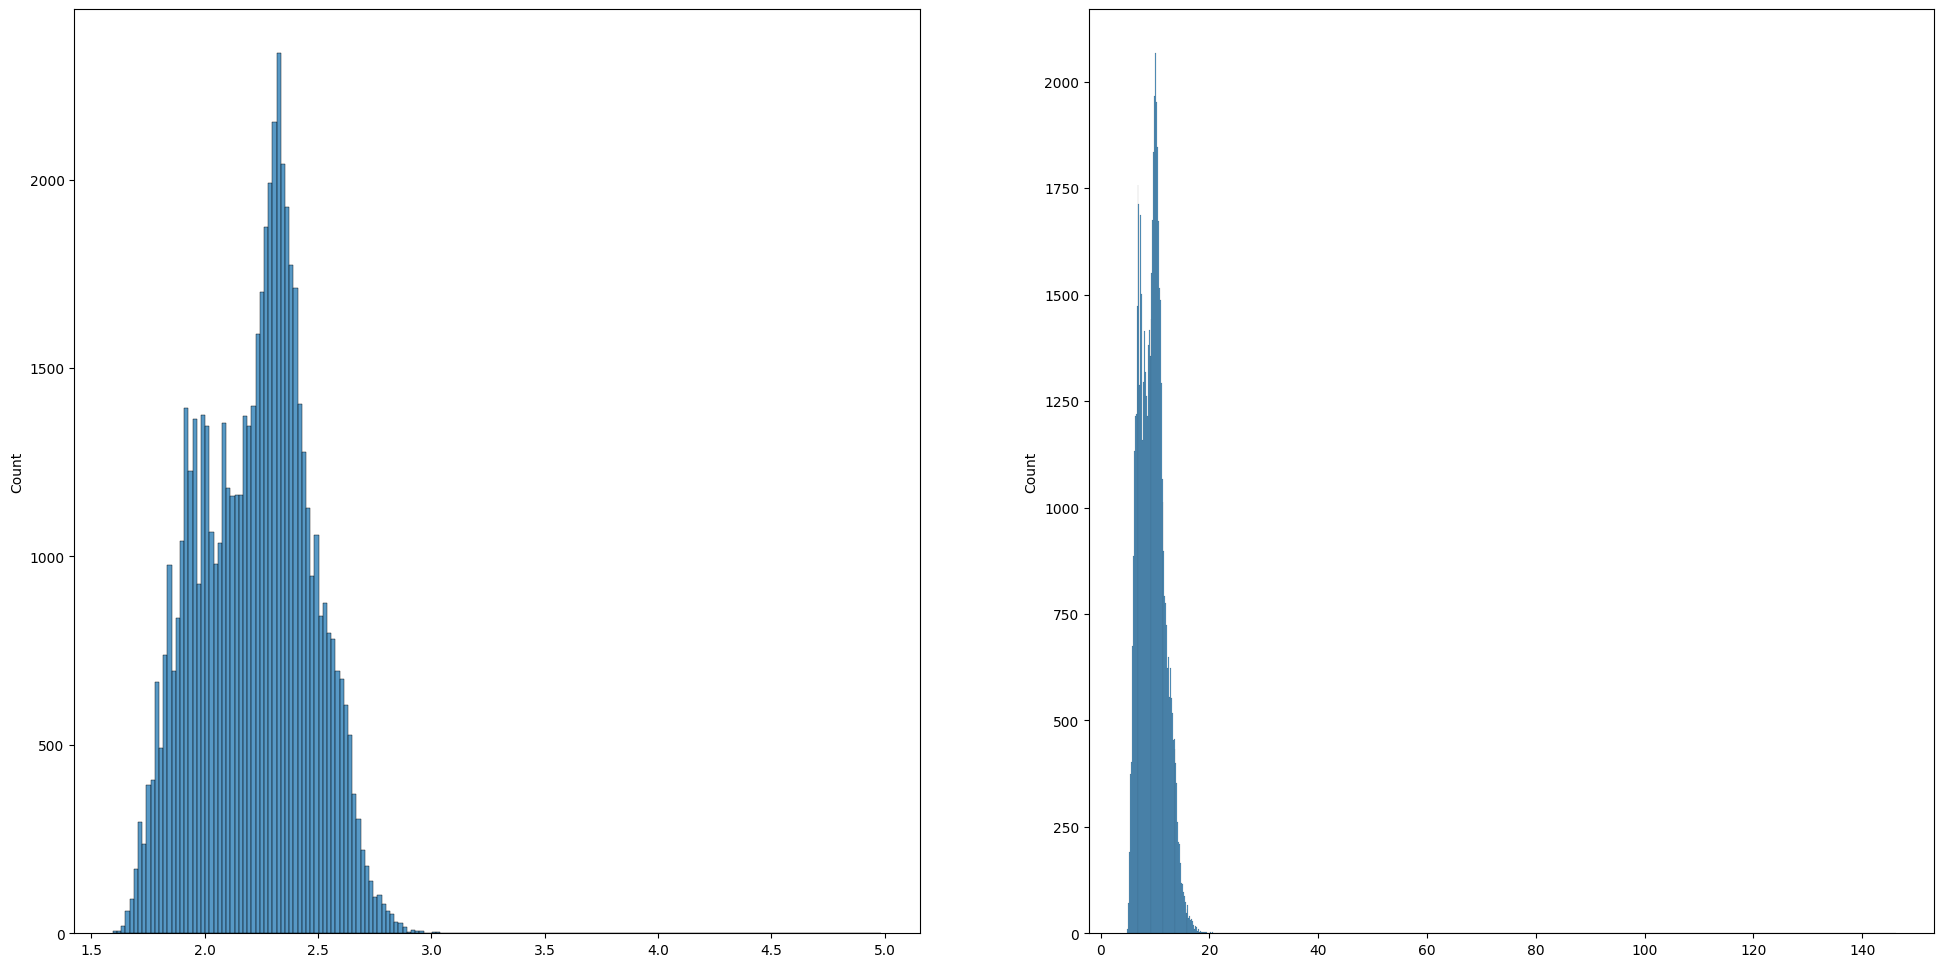

In [106]:
fig, ax = plt.subplots(1, 2, figsize = (24, 12))
sns.histplot(test_predictions, ax = ax[0]);
sns.histplot(test_predictions_inverse_transformed, ax = ax[1]);

In [114]:
test['Rings'] = np.round(test_predictions_inverse_transformed, decimals = 0)
test.head()
test_out = test[['id', 'Rings']]
test_out.head()

,id,Rings
0,90615,11.0
1,90616,11.0
2,90617,10.0
3,90618,10.0
4,90619,7.0


## **Out to CSV**

In [115]:
test_out.to_csv(path+'/AbaloneRegressions_Submission.csv')

## **Summary of Steps**

- We performed EDA, univariate and bivariate analysis, on all the variables in the dataset.
- We then performed missing values treatment using the relationship between variables.
- We started the model building process with all the features.
- We removed multicollinearity from the data and analyzed the model summary report to drop insignificant features.
- We checked for different assumptions of linear regression and fixed the model iteratively if any assumptions did not hold true.
- Finally, we evaluated the model using different evaluation metrics.